In [2]:
import pathlib, re, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION
from elyawy.io import load_sims_df
from scipy import stats as st
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin# define the transformer

class StandardMemoryScaler(BaseEstimator, TransformerMixin):

    def __init__(self, epsilon=1e-4):
        self._epsilon = epsilon
        
    def fit(self, X, y = None):
        self._mean = X.mean()
        self._std = X.std()

        return self

    def transform(self, X):
        X = (X-self._mean)/(self._std+self._epsilon)
       
        return X

    def inverse_transform(self, X_scaled):
        X = X_scaled*(self._std+self._epsilon) + self._mean
        return X


In [3]:
MAIN_PATH = '''/home/elyawy/Data'''

MAIN_PATH = pathlib.Path(re.sub(r"\n\s*","", MAIN_PATH))

In [4]:
true_stats_with_params = pd.DataFrame()
realinged_stats = pd.DataFrame()
for data in ["test"]:
    temp_true_df = pd.read_parquet(MAIN_PATH / data / "true_stats.parquet.gzip")
    temp_realigned_df = pd.read_parquet(MAIN_PATH / data / "realigned_stats.parquet.gzip")
    true_stats_with_params = pd.concat([true_stats_with_params,temp_true_df])
    realinged_stats = pd.concat([realinged_stats,temp_realigned_df])
true_stats_with_params = true_stats_with_params.reset_index(drop=True)
realinged_stats = realinged_stats.reset_index(drop=True)

In [5]:
shuffle_index = list(range(len(true_stats_with_params)))
np.random.seed(420)
np.random.shuffle(shuffle_index)
X = true_stats_with_params.loc[shuffle_index,:].reset_index(drop=True)
Y = realinged_stats.loc[shuffle_index,:].reset_index(drop=True)

In [39]:
examined_stat = "19"
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y[examined_stat],
                                                    train_size=0.8, random_state=420)

In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
394,671,0.011297,0.011297,1.824613,1.824613,4.729198,1013.0,817.0,583.0,661.0,...,5.0,2.0,0.0,9.0,10.0,3.0,345.0,88.0,135.0,125.0
345,855,0.018717,0.018717,2.073490,2.073490,3.861871,1427.0,986.0,834.0,1390.0,...,8.0,7.0,5.0,22.0,13.0,8.0,538.0,127.0,128.0,319.0
1743,830,0.047776,0.047776,2.062102,2.062102,5.882649,2511.0,1248.0,812.0,2582.0,...,29.0,13.0,2.0,100.0,64.0,2.0,140.0,162.0,234.0,651.0
149,684,0.010383,0.010383,1.243095,1.243095,18.396396,1517.0,850.0,559.0,444.0,...,3.0,4.0,0.0,21.0,6.0,3.0,212.0,154.0,183.0,487.0
679,859,0.037752,0.037752,1.421995,1.421995,25.810365,2887.0,940.0,449.0,849.0,...,13.0,3.0,0.0,75.0,46.0,1.0,26.0,47.0,59.0,1202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,714,0.023763,0.023763,1.966083,1.966083,3.010332,1121.0,781.0,636.0,1355.0,...,7.0,7.0,4.0,27.0,9.0,7.0,402.0,144.0,74.0,238.0
575,889,0.017253,0.017253,1.295907,1.295907,21.573871,2685.0,1498.0,689.0,819.0,...,8.0,3.0,0.0,56.0,35.0,1.0,87.0,185.0,183.0,1093.0
390,876,0.011047,0.011047,1.660571,1.660571,5.813350,1375.0,1025.0,754.0,809.0,...,3.0,6.0,1.0,28.0,22.0,2.0,426.0,193.0,150.0,175.0
1096,697,0.048056,0.048056,1.265161,1.265161,54.507519,3514.0,1131.0,105.0,532.0,...,11.0,1.0,0.0,88.0,35.0,0.0,2.0,1.0,24.0,2051.0


In [40]:
scaler = StandardMemoryScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
clf_model = ZeroInflatedPoisson(endog=y_train, exog=X_train)

clf = clf_model.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.299070
         Iterations: 123
         Function evaluations: 124
         Gradient evaluations: 124


In [48]:
clf.predict(X_test)

1787    0.102843
1197    0.120912
882     0.108588
730     0.100262
233     0.134333
          ...   
1979    0.082711
1       0.096109
1729    0.094029
942     0.124921
1042    0.095758
Length: 400, dtype: float64

In [50]:
print(np.sqrt(mean_squared_error(y_test, clf.predict(X_test))))
print(st.pearsonr(clf.predict(X_test), y_test)[0])

0.22689733976188403
0.06144715639344405


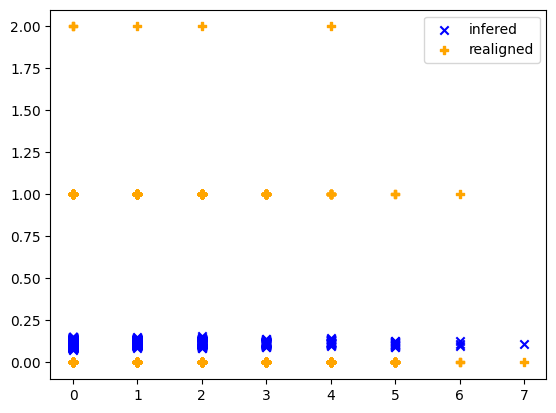

In [51]:
# x_true = X_test[str(int(examined_stat)+5)]
# x_true = X_train[str(int(examined_stat)+5)]
x_true = scaler.inverse_transform(X_train)[str(int(examined_stat)+5)]

plt.scatter(x_true, clf.predict(X_train),
            marker='x', label="infered", c="blue")
plt.scatter(x_true, y_train,
            marker="P", label="realigned", c="orange")
            
plt.legend()
# plt.scatter(true_stats[selected_feature], infered_stat,
#             marker="P", label="infered")
# plt.scatter(true_stats[selected_feature], realinged_stats[selected_feature],
#             marker='x', label="realigned")
